In [1]:
import pandas as pd
import numpy as np
import io
import sys
import os
import matplotlib.pyplot as plt
from utils import standardize_data

In [2]:
import boto3
import sagemaker

In [3]:
s3_client = boto3.client('s3')
bucket_name = 'wildfires'

In [4]:
# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

# print object(s)in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])

In [5]:
file_name = files[0]
# get an S3 object by passing in the bucket and file name
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

In [6]:
# information is in the "Body" of the object
data_body = data_object["Body"].read()
data_stream = io.BytesIO(data_body)
df = pd.read_pickle(data_stream)

In [7]:
print('original rows, cols: ', df.shape)
# drop any incomplete data
clean_df = df.dropna(axis=0)
print('clean rows, cols: ', clean_df.shape)

original rows, cols:  (1880465, 11)
clean rows, cols:  (997827, 11)


By dropping nan values we lose half of the data points. Instead, we will use a function that replace the nan values by the mean or by the most common entry, depending on the case.

In [8]:
for column_name in df.columns:
    print("Number of NaN values for {} is {}".format(column_name, len(df) - df[column_name].count()))

Number of NaN values for FIRE_YEAR is 0
Number of NaN values for DISCOVERY_DATE is 0
Number of NaN values for DISCOVERY_DOY is 0
Number of NaN values for DISCOVERY_TIME is 882638
Number of NaN values for LATITUDE is 0
Number of NaN values for LONGITUDE is 0
Number of NaN values for FIRE_SIZE is 0
Number of NaN values for FIRE_SIZE_CLASS is 0
Number of NaN values for STAT_CAUSE_CODE is 0
Number of NaN values for STAT_CAUSE_DESCR is 0
Number of NaN values for STATE is 0


Standarization techniques:

* Convert discovery time column into integers and then into categorical: Morning (0500-1200), Afternoon(1201-1800) and Night(1801-2400, 0000-0459)


In [9]:
def discretized_time(x):
    x_time = int(x)
    if x_time >= 500 and x_time <= 1200: 
        return "Morning"
    elif x_time >= 1201 and x_time <= 1800:
        return "Afternoon"
    else:
        return "Night"

df["DISCOVERY_PART_OF_DAY"] = df["DISCOVERY_TIME"].apply(lambda x: discretized_time(x) 
                                                         if not pd.isnull(x) else "Unknown")

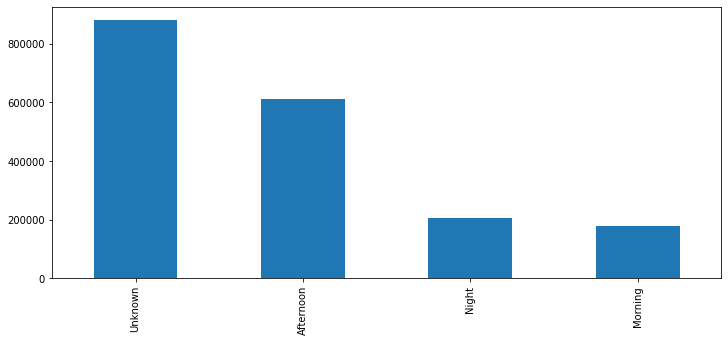

In [10]:
df["DISCOVERY_PART_OF_DAY"].value_counts().plot(kind='bar', figsize=(12,5))

Below, checking the value types for each column are consistent and make sense

In [11]:
final_df = df[['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 
               'STATE', 'DISCOVERY_PART_OF_DAY', 'STAT_CAUSE_CODE']]
print(final_df.dtypes)

FIRE_YEAR                  int64
DISCOVERY_DOY              int64
FIRE_SIZE                float64
STATE                     object
DISCOVERY_PART_OF_DAY     object
STAT_CAUSE_CODE          float64
dtype: object


We need to confirm that all the object types are strings.

In [12]:
object_type_columns = [column_name for column_name in final_df.columns 
                       if pd.api.types.is_object_dtype(final_df[column_name].dtype)]
for column_name in object_type_columns:
    final_df[column_name] = final_df[column_name].astype(str)

Converting the cause code value types to integer for predictions purposes.

In [13]:
final_df['STAT_CAUSE_CODE'].unique()

array([ 9.,  1.,  5.,  4.,  2.,  7.,  8.,  6.,  3., 11., 12., 10., 13.])

In [14]:
final_df['STAT_CAUSE_CODE'] = final_df['STAT_CAUSE_CODE'].astype(int) -1
print(final_df.head(5))
print(final_df['STAT_CAUSE_CODE'].unique())

   FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE STATE DISCOVERY_PART_OF_DAY  \
0       2005             33       0.10    CA             Afternoon   
1       2004            133       0.25    CA               Morning   
2       2004            152       0.10    CA                 Night   
3       2004            180       0.10    CA             Afternoon   
4       2004            180       0.10    CA             Afternoon   

   STAT_CAUSE_CODE  
0                8  
1                0  
2                4  
3                0  
4                0  
[ 8  0  4  3  1  6  7  5  2 10 11  9 12]


Let's create train, validation and test sets, before applying any standarization and normalization techniques to avoid data leakage. 

In [15]:
def train_test_split_data(data, train_frac=0.8, seed=42):
    # convert the df into a matrix for ease of splitting
#     df_matrix = data.to_numpy()
    n = data.shape[0]
    
    # shuffle the data
#     np.random.seed(seed)
#     np.random.shuffle(df_matrix)
    data = data.sample(frac=1)

    # split the data
    train_size = int(n * train_frac)
    diff_size = int(n-train_size)
    val_size = int(train_size + np.ceil(diff_size/2))
    # features are all but last column
    train_features  = data.iloc[:train_size, :-1].reset_index(drop=True)
    # class labels *are* last column
    train_labels = data.iloc[:train_size, -1].reset_index(drop=True)
    # val data
    val_features = data.iloc[train_size:val_size, :-1].reset_index(drop=True)
    val_labels = data.iloc[train_size:val_size, -1].reset_index(drop=True)
    # test data
    test_features = data.iloc[val_size:, :-1].reset_index(drop=True)
    test_labels = data.iloc[val_size:, -1].reset_index(drop=True)
    
    return (train_features, train_labels), (val_features, val_labels), (test_features, test_labels)

In [16]:
def train_test_split_data_per_year(data):
    
    train_features = data[data['FIRE_YEAR']<= 2011].iloc[:,:-1]
    train_labels  =  data[data['FIRE_YEAR']<= 2011].iloc[:,-1]
    val_features = data[(data['FIRE_YEAR'] >= 2012) & (data['FIRE_YEAR'] <= 2013)].iloc[:,:-1]
    val_labels = data[(data['FIRE_YEAR'] >= 2012) & (data['FIRE_YEAR'] <= 2013)].iloc[:,-1]
    test_features = data[(data['FIRE_YEAR'] >= 2014) & (data['FIRE_YEAR'] <= 2015)].iloc[:,:-1]
    test_labels = data[(data['FIRE_YEAR'] >= 2014) & (data['FIRE_YEAR'] <= 2015)].iloc[:,-1]
    
    return (train_features, train_labels), (val_features, val_labels), (test_features, test_labels)

In [19]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = train_test_split_data_per_year(final_df)

Checking all sizes add up to the final data frame shape.

In [20]:
assert(train_x.shape[0] + val_x.shape[0] + test_x.shape[0] == final_df.shape[0])
assert(train_y.shape[0] + val_y.shape[0] + test_y.shape[0] == final_df.shape[0])

In [22]:
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(1600672, 5)
(137549, 5)
(142244, 5)


In [23]:
standardized_train_x = standardize_data(train_x)
standardized_val_x = standardize_data(val_x)
standardized_test_x = standardize_data(test_x)

Saving the train, validation and test sets. 

In [24]:
def make_csv(x, y, filename, data_dir):
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    # your code here
    df_x = pd.DataFrame(x)
    df_y = pd.DataFrame(y) 
    df = pd.concat([df_y, df_x], axis=1)
    df = df.dropna()
    df.to_csv(os.path.join(data_dir,filename), header=False, index=False)
    
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [25]:
data_dir = 'wildfire_data'

make_csv(standardized_train_x, train_y, filename='train.csv', data_dir=data_dir)
make_csv(standardized_val_x, val_y, filename='validation.csv', data_dir=data_dir)
standardized_test_x.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
test_y.to_csv(os.path.join(data_dir, 'test_y.csv'), header=False, index=False)

Path created: wildfire_data/train.csv
Path created: wildfire_data/validation.csv


In [37]:
len(test_y)

188046

In [39]:
df.head(5)

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,LATITUDE,LONGITUDE,FIRE_SIZE,FIRE_SIZE_CLASS,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,STATE,DISCOVERY_PART_OF_DAY
0,2005,2453403.5,33,1300,40.036944,-121.005833,0.10,A,9.0,Miscellaneous,CA,Afternoon
1,2004,2453137.5,133,0845,38.933056,-120.404444,0.25,A,1.0,Lightning,CA,Morning
2,2004,2453156.5,152,1921,38.984167,-120.735556,0.10,A,5.0,Debris Burning,CA,Night
3,2004,2453184.5,180,1600,38.559167,-119.913333,0.10,A,1.0,Lightning,CA,Afternoon
4,2004,2453184.5,180,1600,38.559167,-119.933056,0.10,A,1.0,Lightning,CA,Afternoon


# cause_for_code = {}
code_unique = df['STAT_CAUSE_CODE'].unique().astype(int) - 1
cause_unique = df['STAT_CAUSE_DESCR'].unique()
for code in code_unique:
    cause_for_code[code] = df['STAT_CAUSE_DESCR'][df['STAT_CAUSE_CODE'] == code + 1].iloc[0]
print(cause_for_code)